## Outline

1. Data Preprocessing: merging and standardizatio.

2. Linear Regression
3. Logistic Regression
4. Quadratic Discriminant Analysis
5. K-Nearest Neighbors
6. Decision trees
7. Random Forest



In [17]:
# Import some necessary libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import copy
import random

import os

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm



### Get Data

In [18]:
##SP500 Stock data
#this data include almost 30 different hand made variables for all ths SP5OO stocks.
#the details of the variables can be find in the Data_desctption.txt file
firm_data = pd.read_csv('Data/firm_data.csv', parse_dates=['date'])


##Macro economic Data
# This data are collected from Professor Amit Goyal Data base from his site http://www.hec.unil.ch/agoyal/ 
# From his famous work 'A Comprehensive Look at the Empirical Performance of Equity Premium Prediction' 
# where he identified 13 macro economic factor for asset price prediction
Macro = pd.read_csv('Data/Goyal_mac.csv')

In [19]:
print(firm_data.columns)
print(Macro.columns)

Index(['PERMNO', 'date', 'tic', 'ex_ret', 'm_1', 'm_6', 'm_12', 'abs_acc',
       'noa', 'atoq', 'roaq', 'roicq', 'b_mkt', 'b_smb', 'b_hml', 'size',
       'turnover', 'SPREAD', 'grvol', 'Rel2High', 'Rel2low', 'sgrq', 'ivol',
       'tvol', 'lchq', 'c_revtq', 'c_niq', 'grcapx', 'atme', 'beme',
       'cash_ratio'],
      dtype='object')
Index(['ffyear', 'ffmonth', 'D12', 'E12', 'b/m', 'tbl', 'dfy', 'lty', 'tms',
       'ntis', 'infl', 'ltr', 'svar', 'CRSP_SPvwx'],
      dtype='object')


In [20]:
## Some data preprocessing
#you can see macro data are by month and year based but our firm data is day based, 
#so convert firm data into day and month so that we can easily merge two datasets. 
firm_data['ffyear']=firm_data['date'].dt.year
firm_data['ffmonth']=firm_data['date'].dt.month
Combine_data = pd.merge( firm_data, Macro, how='inner', on=['ffyear', 'ffmonth'])

#delete the extra columns 'PERMNO', 'ffyear', 'ffmonth'
Combine_data.drop(['PERMNO', 'ffyear', 'ffmonth'],axis = 1,  inplace = True)
Combine_data.sort_values(by=['date', 'tic'], inplace = True)
Combine_data.set_index(['date','tic'], inplace = True)

#forward fill the missing value with previous month value for each firm
Combine_data = Combine_data.groupby('tic').ffill().fillna(0)
Combine_data.reset_index(inplace = True)
#Combine_data.drop('tic', axis = 1, inplace = True)
#Combine_data.reset_index(inplace = True)


print(Combine_data.columns)

Index(['date', 'tic', 'ex_ret', 'm_1', 'm_6', 'm_12', 'abs_acc', 'noa', 'atoq',
       'roaq', 'roicq', 'b_mkt', 'b_smb', 'b_hml', 'size', 'turnover',
       'SPREAD', 'grvol', 'Rel2High', 'Rel2low', 'sgrq', 'ivol', 'tvol',
       'lchq', 'c_revtq', 'c_niq', 'grcapx', 'atme', 'beme', 'cash_ratio',
       'D12', 'E12', 'b/m', 'tbl', 'dfy', 'lty', 'tms', 'ntis', 'infl', 'ltr',
       'svar', 'CRSP_SPvwx'],
      dtype='object')


In [21]:
Combine_data

,date,tic,ex_ret,m_1,m_6,m_12,abs_acc,noa,atoq,roaq,...,b/m,tbl,dfy,lty,tms,ntis,infl,ltr,svar,CRSP_SPvwx
0,1990-01-31,AAL,-0.647586,-0.079365,-0.156364,-0.029289,741.700,5903.400,0.460693,0.003576,...,0.414971,0.0764,0.0095,0.0865,0.0101,-0.013792,0.010309,-0.0343,0.002892,-0.069407
1,1990-01-31,AAPL,-0.605461,-0.203390,-0.113208,-0.066225,227.846,733.547,2.035838,0.044374,...,0.414971,0.0764,0.0095,0.0865,0.0101,-0.013792,0.010309,-0.0343,0.002892,-0.069407
2,1990-01-31,ABMD,-0.740455,-0.083333,-0.128713,0.000000,0.638,0.866,0.530581,-0.017553,...,0.414971,0.0764,0.0095,0.0865,0.0101,-0.013792,0.010309,-0.0343,0.002892,-0.069407
3,1990-01-31,ABT,-0.608971,-0.018051,0.034221,0.387755,544.458,2824.975,0.497846,0.052155,...,0.414971,0.0764,0.0095,0.0865,0.0101,-0.013792,0.010309,-0.0343,0.002892,-0.069407
4,1990-01-31,ADBE,-0.407037,0.051948,-0.109890,-0.124324,6.164,9.655,3.078801,0.106661,...,0.414971,0.0764,0.0095,0.0865,0.0101,-0.013792,0.010309,-0.0343,0.002892,-0.069407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163947,2018-12-31,XRAY,-0.202771,0.090962,-0.136852,-0.426098,174.100,6468.800,0.159629,0.000207,...,0.255578,0.0237,0.0111,0.0284,0.0047,-0.019217,-0.003194,0.0481,0.006793,-0.092457
163948,2018-12-31,XRX,-0.446686,-0.034087,0.121667,-0.076501,1541.000,7207.000,0.267476,0.009211,...,0.255578,0.0237,0.0111,0.0284,0.0047,-0.019217,-0.003194,0.0481,0.006793,-0.092457
163949,2018-12-31,YRCW,-0.633463,-0.314770,-0.436816,-0.606398,69.500,341.800,3.407266,0.010822,...,0.255578,0.0237,0.0111,0.0284,0.0047,-0.019217,-0.003194,0.0481,0.006793,-0.092457
163950,2018-12-31,YUM,-0.193253,0.020020,0.178982,0.130009,158.000,1489.000,0.804752,0.080872,...,0.255578,0.0237,0.0111,0.0284,0.0047,-0.019217,-0.003194,0.0481,0.006793,-0.092457


In [9]:
print(Combine_data.head)

<bound method NDFrame.head of              date   tic    ex_ret       m_1       m_6      m_12   abs_acc  \
0      1990-01-31   AAL -0.647586 -0.079365 -0.156364 -0.029289   741.700   
1      1990-01-31  AAPL -0.605461 -0.203390 -0.113208 -0.066225   227.846   
2      1990-01-31  ABMD -0.740455 -0.083333 -0.128713  0.000000     0.638   
3      1990-01-31   ABT -0.608971 -0.018051  0.034221  0.387755   544.458   
4      1990-01-31  ADBE -0.407037  0.051948 -0.109890 -0.124324     6.164   
...           ...   ...       ...       ...       ...       ...       ...   
163947 2018-12-31  XRAY -0.202771  0.090962 -0.136852 -0.426098   174.100   
163948 2018-12-31   XRX -0.446686 -0.034087  0.121667 -0.076501  1541.000   
163949 2018-12-31  YRCW -0.633463 -0.314770 -0.436816 -0.606398    69.500   
163950 2018-12-31   YUM -0.193253  0.020020  0.178982  0.130009   158.000   
163951 2018-12-31  ZION -0.352762  0.034219 -0.076485 -0.042691  2694.000   

             noa      atoq      roaq  ...    

#### Train test split

In [22]:
#Remember in financial data we cannot divide data into train and testing set randomely, 
#we need to keep in mind the time continueity, earlier data for trainin and later data for testing. 
#Therefore here, we train the model on data from 1990 till 2012 and test the model from 2013 to 2019.

Combine_data_train = Combine_data[(Combine_data['date'] < '2013-01-01')]
Combine_data_test = Combine_data[(Combine_data['date'] > '2013-01-01')]

# set the index as date and tic, beacuse they are not data, rather one denote the date and tic denote the firm name
Combine_data_train.set_index(['date','tic'], inplace = True)
Combine_data_test.set_index(['date','tic'], inplace = True)

In [25]:
Combine_data_test.describe()

,ex_ret,m_1,m_6,m_12,abs_acc,noa,atoq,roaq,roicq,b_mkt,...,b/m,tbl,dfy,lty,tms,ntis,infl,ltr,svar,CRSP_SPvwx
count,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.00000,...,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000,34113.000000
mean,-0.027299,0.010332,0.054588,0.123654,6483.789099,8268.541560,0.376837,0.014542,0.115601,1.04087,...,0.301757,0.005339,0.008820,0.027757,0.022418,-0.009395,0.001252,0.002452,0.001381,0.008477
std,0.104831,0.122184,0.250100,0.396206,44849.784001,49917.336914,8.265526,0.050961,2.562945,0.56032,...,0.037555,0.007008,0.002146,0.004468,0.007936,0.013972,0.002884,0.027198,0.001372,0.030564
min,-0.756296,-0.853191,-0.940741,-0.970999,0.081000,-787970.000000,-829.250000,-0.423566,-4.138889,-1.53000,...,0.222519,0.000200,0.005500,0.017500,0.004700,-0.032544,-0.005670,-0.062900,0.000150,-0.092457
25%,-0.080871,-0.032360,-0.050549,-0.051343,93.400000,1130.000000,0.127933,0.003806,0.007914,0.67480,...,0.272545,0.000300,0.007000,0.025600,0.015500,-0.020256,-0.000632,-0.017000,0.000503,-0.004457
50%,-0.017435,0.009472,0.047965,0.098357,389.000000,3916.839000,0.275478,0.011554,0.019419,1.01010,...,0.313685,0.001200,0.008700,0.027400,0.022700,-0.012139,0.001203,0.001200,0.000907,0.010511
75%,0.034586,0.051208,0.142810,0.254147,1299.000000,12327.000000,0.567084,0.022223,0.034802,1.34740,...,0.330902,0.009800,0.009500,0.030900,0.028400,0.005656,0.003493,0.017400,0.001673,0.028398
max,1.652000,12.198276,8.244275,9.433616,728111.000000,382510.000000,180.500000,0.991704,142.777778,4.50110,...,0.350616,0.023700,0.014900,0.037800,0.037100,0.016696,0.008190,0.070900,0.006793,0.082049


#### Data standardization

In [26]:
## The Success of machine learning model often depend on data normalization/standardization, 
# so we here standardize our data in 0 mean and 1 standard deviation, we use a skitlear library for that.
# Notice that we fit and transform for training data but just transform the test data, 
# beacuse we assume we do not see the test data before hand, 
# if we transform for test data too, it will induce infromation leakage. 
scaler = StandardScaler()
Train = scaler.fit_transform(Combine_data_train)
Test = scaler.transform(Combine_data_test)
#remember we are only transforming the test data not fitting it

In [31]:
# We define our X and Y variables, remeber our goal is to pedict excess return, so this is our Y variable, 
# and all others variable are X variables. 
Train_Y = Train[:,0]
Train_X = Train[:,1:]

Test_Y = Test[:,0]
Test_X = Test[:,1:]

In [32]:
Train.shape

(129839, 40)

In [33]:
Train_X.shape

(129839, 39)

In [35]:
Train_Y

array([-1.86259684, -1.66726819, -2.29321942, ...,  0.91547038,
        1.04681006,  1.40109102])

## Linear Regression Model

In [36]:
# Fit the model.
lm = LinearRegression().fit(Train_X, Train_Y)

In [37]:
# Predict the values on training and testing data. 
TrainPredictedY = lm.predict(Train_X)
TestPredictedY = lm.predict(Test_X)


In [38]:
print ('Training MSE is', 
       mean_squared_error(TrainPredictedY.tolist(), Train_Y.tolist()))
print ('Testing MSE is', 
       mean_squared_error(TestPredictedY.tolist(), Test_Y.tolist()))

#The means square is pretty low, but lets see can we reduce it further. 

Training MSE is 0.23581067234943695
Testing MSE is 0.10901507475507666


In [39]:
print ('Training R-squared is', 
       r2_score(TrainPredictedY.tolist(), Train_Y.tolist()))
print ('Testing R-squared is', 
       r2_score(TestPredictedY.tolist(), Test_Y.tolist()))


Training R-squared is 0.6913701463967005
Testing R-squared is 0.05715217030688646


In [29]:
dir(lm)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_residues',
 '_set_intercept',
 '_validate_data',
 'coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_features_in_',
 'n_jobs',
 'normalize',
 'positive',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

In [28]:
# you can also see the coeffiecint for each variables.
lm.coef_

array([-3.44134140e-02, -5.75883551e-02, -5.25573074e-02, -7.81775332e-04,
        1.04154991e-03,  2.36961454e-04,  1.89406274e-03, -1.94343001e-03,
       -3.01825048e-03,  8.08410652e-03, -1.40474905e-03,  2.00266622e-02,
        1.37504284e-02,  5.11508054e-03,  2.43369914e-02,  1.80254669e-01,
        7.73981499e-02,  9.70999163e-02,  1.01679659e-02,  7.26641802e-02,
       -1.94362130e-02, -9.27007947e-02,  3.45463337e-03,  1.34819301e-03,
       -6.71441887e-03,  3.51964509e-04,  3.09330198e-03,  4.43862540e-02,
       -3.54361245e-02, -1.57948954e-02, -2.96521938e+11,  9.88209395e-02,
        2.07034953e+11, -1.88886742e+11,  5.24036207e-02, -3.05824157e-03,
       -1.19492375e-02, -5.39780886e-02,  1.83252024e-01])

In [40]:
# you can also see the intercept.
lm.intercept_

7.535632864077741e-05

## Logistic Regression 

In [43]:
# Unlike regression in logistic regression the outcome variable (Y) need to be catagorical (0 or 1)  
# therefore our first task is to convert the contineous return varauble (Y) to binary variable. 
# where we define a positive return (profit) as 1 and negative retrun (loss) as 0. 
# I here create to other Y varaible Y_tr for training and Y_ts for testing, 
# I used copy beacuse don't wanna overwrite on the actual return. 

Y_tr = Train_Y.copy()
Y_tr[Y_tr >= 0] = 1
Y_tr[Y_tr < 0] = 0



Y_ts = Test_Y.copy()
Y_ts[Y_ts >= 0] = 1
Y_ts[Y_ts < 0] = 0


In [45]:
#You can also see how many prositive and how many negative return in training data
# as you can see in training data both 1 and 0 are almost equally distrubuted  
#we can therefore considered the data set as balance 

unique, counts = np.unique(Y_tr, return_counts=True)
dict(zip(unique, counts))


{0.0: 68195, 1.0: 61644}

In [46]:
# for logistic regression we only run model with first 30 variables
regr = sm.Logit(Y_tr, Train_X[:,0:30]).fit()

Optimization terminated successfully.
         Current function value: 0.491130
         Iterations 8


In [47]:
print(regr.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.290      
Dependent Variable: y                AIC:              127595.5594
Date:               2022-08-25 17:44 BIC:              127888.7809
No. Observations:   129839           Log-Likelihood:   -63768.    
Df Model:           29               LL-Null:          -89832.    
Df Residuals:       129809           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
x1        -0.8203     0.0568   -14.4375   0.0000   -0.9317   -0.7089
x2        -1.4006     0.0363   -38.6359   0.0000   -1.4717   -1.3296
x3        -0.9407     0.0268   -35.1041   0.0000   -0.9932   -0.8881
x4       

In [48]:
#print the confusion matrix for training data
pred = regr.predict(Train_X[:,0:30])

result = [1 if r > .5 else 0 for r in pred]
print('Confusion Matrix for training data')
print(confusion_matrix( y_true = Y_tr, y_pred = result))

Confusion Matrix for training data
[[56049 12146]
 [17879 43765]]


In [57]:
## print the accuracy score 
print(accuracy_score(y_true = Y_tr, y_pred = result)) 

0.7687520698711481


In [49]:
#print the confusion matrix for test data
pred_test = regr.predict(Test_X[:,0:30])

result_test = [1 if r > .5 else 0 for r in pred_test]
print('Confusion Matrix for training data')
print(confusion_matrix( y_true = Y_ts, y_pred = result_test))  

Confusion Matrix for training data
[[    9  1062]
 [   30 33012]]


In [50]:
## print the accuracy score 
print(accuracy_score(y_true = Y_ts, y_pred = result_test)) 

0.9679887432943453


## Linear Discriminant Analysis

In [51]:

clf = LinearDiscriminantAnalysis()
clf.fit(Train_X, Y_tr)

print(clf.priors_, '\n') 
print(clf.means_, '\n')
print(clf.coef_, '\n')


[0.5252274 0.4747726] 

[[-4.01347827e-03 -4.22849243e-03 -1.09531722e-02 -3.03995881e-02
  -1.84982003e-02  3.83537884e-03  1.21037033e-02  5.64681080e-03
  -3.38879048e-02 -1.66495077e-02 -3.55145693e-02 -1.29826048e-01
  -1.80105200e-01 -3.47515173e-03  3.02241469e-02 -9.08721049e-02
  -3.30547929e-02  6.71434005e-03 -1.15577078e-01 -1.59998524e-01
  -3.41322651e-01  5.54970113e-03  1.64586062e-03  6.61543204e-04
  -8.34534085e-04  5.20753711e-03 -5.46091625e-02 -3.40358230e-01
  -1.21124327e-01 -1.62110826e-01  7.39143096e-01 -3.52782133e-01
   5.24242796e-01 -5.85724332e-01  1.07383939e-01  7.83905383e-02
   1.35928131e-02 -7.95269305e-02 -6.59973817e-02]
 [ 4.43999660e-03  4.67786064e-03  1.21171822e-02  3.36301978e-02
   2.04640317e-02 -4.24297028e-03 -1.33899820e-02 -6.24690582e-03
   3.74892231e-02  1.84188757e-02  3.92887557e-02  1.43622856e-01
   1.99245248e-01  3.84446129e-03 -3.34361122e-02  1.00529219e-01
   3.65675751e-02 -7.42788300e-03  1.27859626e-01  1.77001807e-01
 

In [52]:
## Confusion Matrix of LDA for training Data
pred = clf.predict(Train_X)
print(clf.classes_, '\n')

result = [1 if r > .5 else 0 for r in pred]
print('Confusion Matrix for training data')
print(confusion_matrix(y_pred = result, y_true = Y_tr))

[0. 1.] 

Confusion Matrix for training data
[[62359  5836]
 [ 7811 53833]]


In [53]:
## accuracy score for training data
print(accuracy_score(y_true = Y_tr, y_pred = result)) 

0.8948929058295273


In [54]:
#print the confusion matrix for LDA for test data
pred_test = clf.predict(Test_X)

result_test = [1 if r > .5 else 0 for r in pred_test]
print('Confusion Matrix for test data')
print(confusion_matrix(y_pred = result_test, y_true = Y_ts))  

Confusion Matrix for test data
[[  986    85]
 [ 9918 23124]]


In [65]:
## print the accuracy score 
print('Accuracy score for test data')
print(accuracy_score(y_true = Y_ts, y_pred = result_test)) 

Accuracy score for test data
0.7067686805616628


## Quadratic Discriminant Analysis

In [66]:
clf = QuadraticDiscriminantAnalysis()
clf.fit( Train_X, Y_tr)
print(clf.priors_, '\n')
print(clf.means_, '\n')

[0.5252274 0.4747726] 

[[-4.01347827e-03 -4.22849243e-03 -1.09531722e-02 -3.03995881e-02
  -1.84982003e-02  3.83537884e-03  1.21037033e-02  5.64681080e-03
  -3.38879048e-02 -1.66495077e-02 -3.55145693e-02 -1.29826048e-01
  -1.80105200e-01 -3.47515173e-03  3.02241469e-02 -9.08721049e-02
  -3.30547929e-02  6.71434005e-03 -1.15577078e-01 -1.59998524e-01
  -3.41322651e-01  5.54970113e-03  1.64586062e-03  6.61543204e-04
  -8.34534085e-04  5.20753711e-03 -5.46091625e-02 -3.40358230e-01
  -1.21124327e-01 -1.62110826e-01  7.39143096e-01 -3.52782133e-01
   5.24242796e-01 -5.85724332e-01  1.07383939e-01  7.83905383e-02
   1.35928131e-02 -7.95269305e-02 -6.59973817e-02]
 [ 4.43999660e-03  4.67786064e-03  1.21171822e-02  3.36301978e-02
   2.04640317e-02 -4.24297028e-03 -1.33899820e-02 -6.24690582e-03
   3.74892231e-02  1.84188757e-02  3.92887557e-02  1.43622856e-01
   1.99245248e-01  3.84446129e-03 -3.34361122e-02  1.00529219e-01
   3.65675751e-02 -7.42788300e-03  1.27859626e-01  1.77001807e-01
 

/Users/ajimuddin/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [67]:
#print the confusion matrix for QDA for test data
pred_test = clf.predict(Test_X)

result_test = [1 if r > .5 else 0 for r in pred_test]
print('Confusion Matrix for test data')
print(confusion_matrix(y_pred = result_test, y_true = Y_ts))  

Confusion Matrix for training data
[[   29  1042]
 [ 8172 24870]]


In [69]:
## print the accuracy score 
print('Accuracy score for test data')
print(accuracy_score(y_pred = result_test, y_true = Y_ts)) 

Accuracy score for test data
0.7298976929616275


## K-Nearest Neighbors

In [70]:
clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit( Train_X, Y_tr)


#print the confusion matrix for QDA for test data
pred_test = clf.predict(Test_X)

result_test = [1 if r > .5 else 0 for r in pred_test]
print('Confusion Matrix for training data')
print(confusion_matrix(y_pred = result_test, y_true = Y_ts))  


Confusion Matrix for training data
[[   28  1043]
 [  172 32870]]


In [72]:
conf = confusion_matrix(y_pred = result_test, y_true = Y_ts)
print(conf, '\n')
print((conf[0,0]+conf[1,1])/len(Y_ts))


[[   28  1043]
 [  172 32870]] 

0.9643830797643127


## Decision trees

In [55]:
import pydotplus # For Python 3.5+ ## 'pydot' for Python 2.7 #
from IPython.display import Image

#from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from io import StringIO
#from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error


In [56]:
# This function creates images of tree models using pydot. #
def print_tree(estimator, features, class_names = None, filled = True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file = dot_data, feature_names = features, class_names = classn, filled = filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [60]:
regr = DecisionTreeRegressor(max_leaf_nodes = 10)
regr.fit(Train_X[:,0:10], Train_Y)


DecisionTreeRegressor(max_leaf_nodes=10)

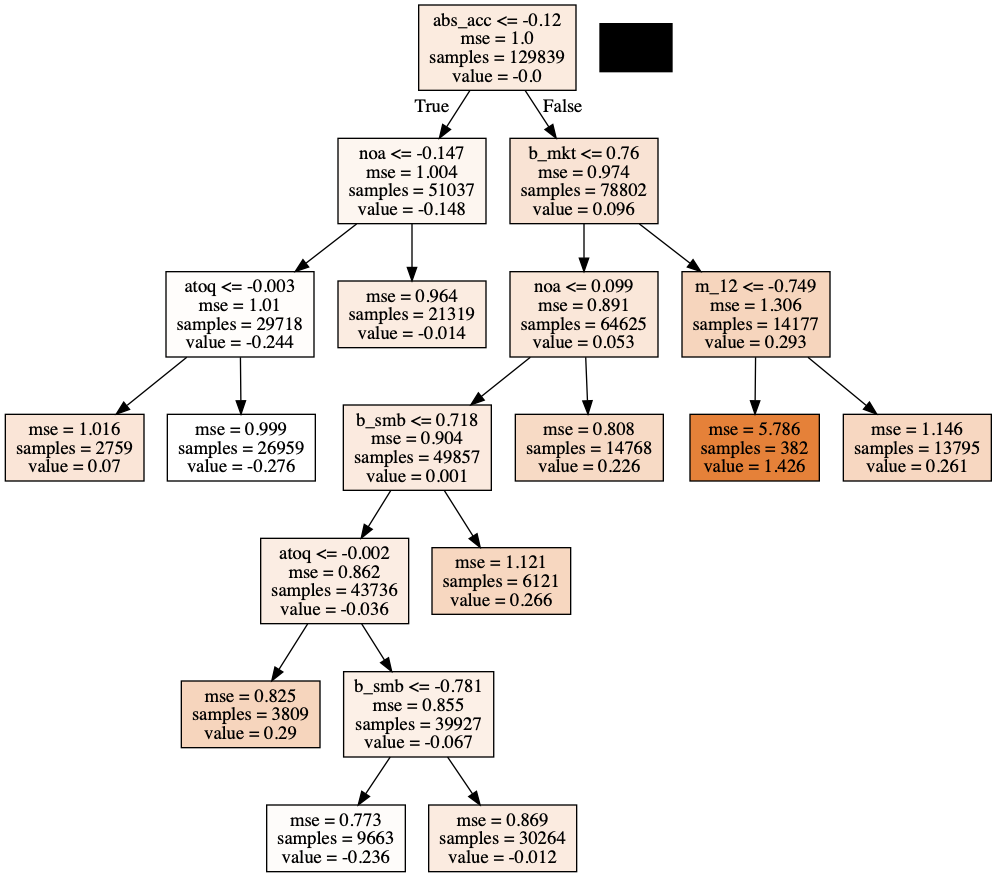

In [62]:
graph = print_tree(regr, features = Combine_data_train.columns[1:11])
Image(graph.create_png()) # Make sure you have 'graphviz'. If not, use 'conda install graphviz' in shell. #


## Decision Tree Classifier

In [68]:
clf = DecisionTreeClassifier(max_depth = 6)
clf.fit(Train_X, Y_tr)

DecisionTreeClassifier(max_depth=6)

In [69]:
#Classification accuracy for Train Data

print(classification_report(Y_tr, clf.predict(Train_X)))
#help(classification_report)

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92     68195
         1.0       0.93      0.89      0.91     61644

    accuracy                           0.92    129839
   macro avg       0.92      0.92      0.92    129839
weighted avg       0.92      0.92      0.92    129839



In [70]:
#Classification accuracy for test Data

print(classification_report(Y_ts, clf.predict(Test_X)))
#help(classification_report)

              precision    recall  f1-score   support

         0.0       0.77      0.42      0.54      1071
         1.0       0.98      1.00      0.99     33042

    accuracy                           0.98     34113
   macro avg       0.87      0.71      0.77     34113
weighted avg       0.97      0.98      0.97     34113



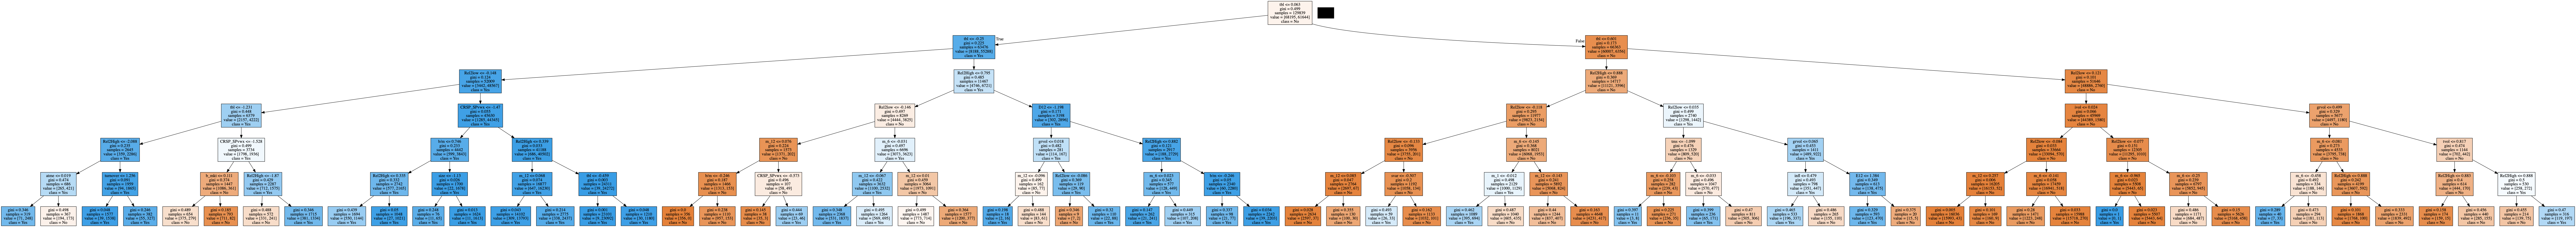

In [71]:
graph3 = print_tree(clf, features=Combine_data_train.columns[1:], class_names=['No', 'Yes'])
Image(graph3.create_png()) 

In [92]:
#print the confusion matrix for LDA for test data
pred_test = clf.predict(Test_X)

result_test = [1 if r > .5 else 0 for r in pred_test]
print('Confusion Matrix for training data')
print(confusion_matrix(y_pred = result_test, y_true = Y_ts))  

Confusion Matrix for training data
[[  451   620]
 [  136 32906]]


## Random Forest Regressor

In [72]:
regr1 = RandomForestRegressor(n_estimators = 20, max_features = 39, random_state = 1)
regr1.fit(Train_X, Train_Y)



RandomForestRegressor(max_features=39, n_estimators=20, random_state=1)

In [73]:
pred = regr1.predict(Test_X)

In [74]:
#Notice the mean squared error, it is much lower than simple multivariate regression of 0.1092
# This signifies the importance of nonlinear model. 
#Mean squared error of test data
mean_squared_error(Test_Y, pred)

0.08406999518632605

In [75]:
r2_score(Test_Y, pred)

0.6441872809733122

Text(0, 0.5, 'Y_ts')

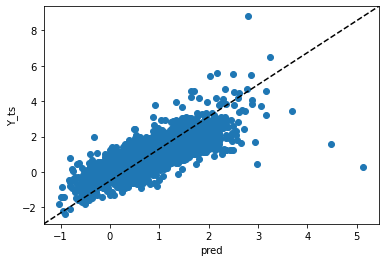

In [76]:
# Lets plot the original and predicted values for test data set in a scatter plot. 
# the closer the values to the diagonal line the better the model.
plt.scatter(pred, Test_Y, label = 'medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('Y_ts')


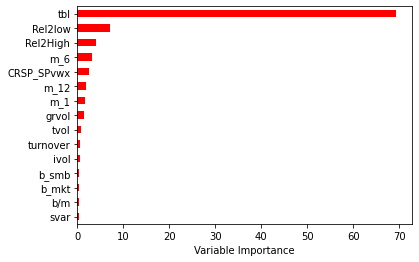

In [77]:
#Lets plot the varaibles according to their feature importance. Only plot the top 15 features. 
Importance = pd.DataFrame({'Importance':regr1.feature_importances_*100}, index=Combine_data_train.columns[1:])
Importance.sort_values('Importance', axis=0, ascending=True).tail(15).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
